In [1]:
# Images and masks will be stored in a dataset in RGB format 
# Images end with .jpg while masks end with .png
# cv2 is used to read images and masks, so they are loaded in BGR
# Right after they are loaded, we convert them to RGB for consistency
# In very step of this code where any image is RGB format, it is indeed RGB not BGR
# The first option is that images are stored in 25cm per pixel resolution
# We work with data from CUZK, where all data are in 12,5cm per pixel resolution so resclase has to be part of preprocesing before this code
# First input will be 256x256x3 tensor later 512x512x3 will be tested
import numpy as np
np.object = object    
np.int = int    
np.float = float    
np.bool = bool 

import os

os.environ["SM_FRAMEWORK"] = "tf.keras"


import re
import random
import pickle

import cv2

import tensorflow
from PIL import Image
from matplotlib import pyplot as plt
from patchify import patchify
from enum import Enum
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from simple_multi_unet_model import *


Segmentation Models: using `tf.keras` framework.


In [2]:
if tensorflow.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

scaler = MinMaxScaler()

root_directory = "/home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3"

patch_size = 256 #mozna zmenim na 512


GPU found


2024-04-25 12:15:04.258213: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 12:15:04.282963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 12:15:04.298727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 12:15:04.298829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [3]:
image_dataset = []

# Sort the directories based on the last number in their names
def get_last_number(filename):
    return int(re.findall(r'\d+', filename)[-1])


for path, subdirs, files in sorted(os.walk(root_directory), key=lambda x: get_last_number(x[0])):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   # Find all 'masks' directories
        images = os.listdir(path)  # List of all mask names in this subdirectory
        for i, img_name in enumerate(sorted(images, key=get_last_number)):
            if img_name.endswith(".jpg"):   # Only read png images (masks in this dataset)
                image = cv2.imread(os.path.join(path, img_name), 1)  # Read each image as RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_x = (image.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
                size_y = (image.shape[0] // patch_size) * patch_size  # Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))  # Crop from top left corner
                image = np.array(image)

                # Extract patches from each image
                if image.shape[0] >= patch_size and image.shape[1] >= patch_size:
                    print("Now patchifying image:", os.path.join(path, img_name))
                    img_patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=patch_size for non-overlapping patches

                for i in range(img_patches.shape[0]):
                    for j in range(img_patches.shape[1]):
                        single_patch_img = img_patches[i, j, :, :]

                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        single_patch_img = single_patch_img[0]  # Drop the extra unnecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)

Now patchifying image: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/images/BOS12_0.jpg
Now patchifying image: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/images/BOS12_1.jpg
Now patchifying image: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/images/BOS12_2.jpg
Now patchifying image: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/images/BOS12_3.jpg
Now patchifying image: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/images/BOS12_4.jpg
Now patchifying image: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/images/BOS12_5.jpg
Now patchifying image: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/images/BOS12_6.jpg
Now patchifying image: /home/nb1/pazdera/

In [4]:
mask_dataset = []

# Sort the directories based on the last number in their names
def get_last_number(filename):
    return int(re.findall(r'\d+', filename)[-1])


for path, subdirs, files in sorted(os.walk(root_directory), key=lambda x: get_last_number(x[0])):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   # Find all 'masks' directories
        masks = os.listdir(path)  # List of all mask names in this subdirectory
        for i, mask_name in enumerate(sorted(masks, key=get_last_number)):
            if mask_name.endswith(".png"):   # Only read png images (masks in this dataset)
                mask = cv2.imread(os.path.join(path, mask_name), 1)  # Read each image as RGB
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                size_x = (mask.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
                size_y = (mask.shape[0] // patch_size) * patch_size  # Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0, 0, size_x, size_y))  # Crop from top left corner
                mask = np.array(mask)

                # Extract patches from each image
                if mask.shape[0] >= patch_size and mask.shape[1] >= patch_size:
                    print("Now patchifying mask:", os.path.join(path, mask_name))
                    mask_patches = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  # Step=patch_size for non-overlapping patches

                for i in range(mask_patches.shape[0]):
                    for j in range(mask_patches.shape[1]):
                        single_patch_mask = mask_patches[i, j, :, :]
                        single_patch_mask = single_patch_mask[0]  # Drop the extra unnecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)







Now patchifying mask: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/masks/BOS12_0.png


Now patchifying mask: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/masks/BOS12_1.png
Now patchifying mask: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/masks/BOS12_2.png
Now patchifying mask: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/masks/BOS12_3.png
Now patchifying mask: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/masks/BOS12_4.png
Now patchifying mask: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/masks/BOS12_5.png
Now patchifying mask: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/masks/BOS12_6.png
Now patchifying mask: /home/nb1/pazdera/datasets/CZ_CUSTOM_DATASET/Semantic segmentation dataset korekce mod3/Tile 1/masks/BOS12_7.png
Now patchifying mask: /home/nb1/pazdera/datasets/CZ_CUS

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

print(image_dataset.shape)
print(mask_dataset.shape)

# print(np.unique(image_dataset))
# print(np.unique(mask_dataset))

(2256, 256, 256, 3)
(2256, 256, 256, 3)


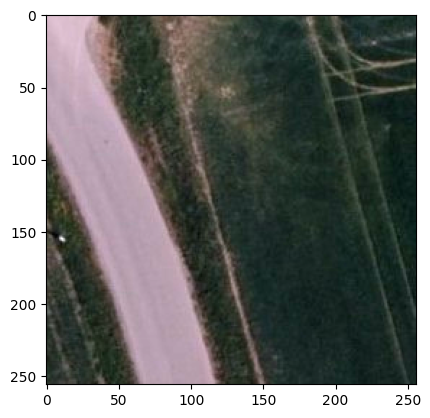

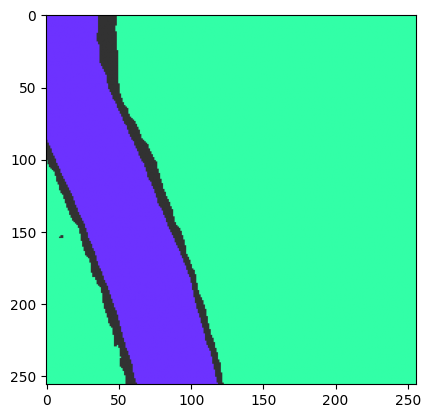

In [6]:
ran_i = random.randint(0,image_dataset.shape[0]-1)
one_image = image_dataset[ran_i,:,:,:]
one_mask = mask_dataset[ran_i,:,:,:]
plt.imshow(one_image)
plt.show()
plt.imshow(one_mask/255.)
plt.show()

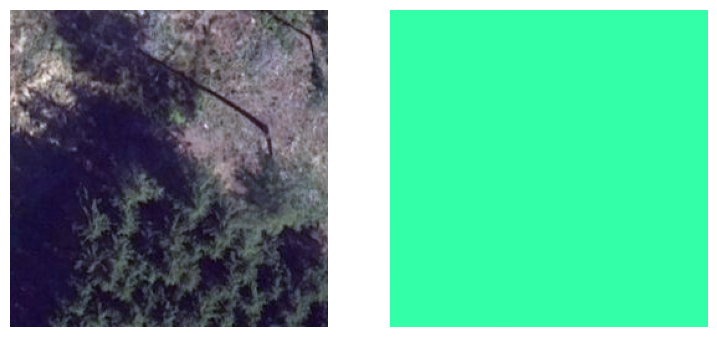

In [7]:
# visually chcecking RGB format of loaded images and masks

r_num = random.randint(0, len(image_dataset)-1)

plt.figure(figsize=(9,6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow((image_dataset[r_num]).astype(np.float32))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow((mask_dataset[r_num]/255).astype(np.float32))

In [8]:
Unlabelled = [50,50,50]
Vegetation = [50,255,167]
Unpaved_road = [255,140,0]
Paved_area = [109,50,255]
Building = [255,225,50]
Water = [50,167,255]
Land = [166, 117, 86]

In [9]:
# Clasess have to be in array format
# Following function converts RGB to integer values representing classes


def rgb_to_2D_label(label):

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Unlabelled,axis=-1)] = 0
    label_seg [np.all(label==Vegetation,axis=-1)] = 1
    label_seg [np.all(label==Unpaved_road,axis=-1)] = 2
    label_seg [np.all(label==Paved_area,axis=-1)] = 3
    label_seg [np.all(label==Building,axis=-1)] = 4
    label_seg [np.all(label==Water,axis=-1)] = 5
    label_seg [np.all(label==Land,axis=-1)] = 6
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [10]:
mask_sample = single_patch_mask
print(mask_sample.shape, np.unique(mask_sample))

single_label = rgb_to_2D_label(mask_sample)
print(single_label.shape, np.unique(single_label))

(256, 256, 3) [ 50 167 255]
(256, 256) [1]


In [11]:
# Converting masks to labels according to defined classes
# Expanding dims so the format is correct for model input

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

# print("Unique labels in label dataset are: ", np.unique(labels))
print("Shape of labels: ", labels.shape)
#print(np.unique(labels))
#print(len(np.unique(labels)))

Shape of labels:  (2256, 256, 256, 1)


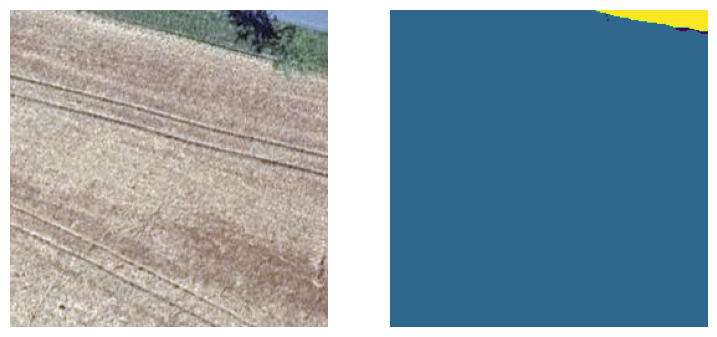

In [12]:
# Sanity check
# The mask colors are not the same as we defined, because the input here is only label with integers <0,5>
# The function imshow uses different color scheme

image_number = random.randint(0, len(image_dataset-1))
plt.figure(figsize=(9,6))
plt.subplot(1, 2, 1)
plt.imshow(image_dataset[image_number].astype(np.float32))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(labels[image_number][:,:,0])
plt.axis('off')
plt.show()

In [13]:
# Setting number of classes for further processing
# Checking if the expected number of classes corresponds to the number of unique labels in our dataset

n_classes = 7

"""
if n_classes == len(np.unique(labels)):
    print("Number of classes is correct")
else:
    print("Houston, we've had a problem")
"""

'\nif n_classes == len(np.unique(labels)):\n    print("Number of classes is correct")\nelse:\n    print("Houston, we\'ve had a problem")\n'

In [14]:
# Converting to onehot encode
# This format corresponds to output of the neural network

labels_cat = to_categorical(labels, num_classes=n_classes)

print(labels_cat.shape)
# print(np.unique(labels_cat))

(2256, 256, 256, 7)


In [15]:
# Dividing all data into train and test parts

X_train, X_test, Y_train, Y_test = train_test_split(image_dataset, labels_cat, test_size=0.10)

# print(X_train.shape, np.unique(X_train))
# print(Y_train.shape, np.unique(Y_train))

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2030, 256, 256, 3)
(2030, 256, 256, 7)
(226, 256, 256, 3)
(226, 256, 256, 7)


In [16]:
# Initialize the parameters of our model

#weights = [0.05, 0.40, 0.30, 0.10, 0.10, 0.05]
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

metrics = ['accuracy', jacard_coef]

In [17]:
# Getting model, summary

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
# model.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=metrics)
model.compile(optimizer='adam', loss = total_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

2024-04-25 12:15:30.987296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 12:15:30.987422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 12:15:30.987477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 12:15:30.988037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 12:15:30.988106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [18]:
history1 = model.fit(X_train, Y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=30, 
                    validation_data=(X_test, Y_test), 
                    shuffle=False)

2024-04-25 12:15:31.300845: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1596456960 exceeds 10% of free system memory.
2024-04-25 12:15:31.823258: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3725066240 exceeds 10% of free system memory.
2024-04-25 12:15:33.059318: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1596456960 exceeds 10% of free system memory.
2024-04-25 12:15:33.474135: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3725066240 exceeds 10% of free system memory.
2024-04-25 12:15:34.453414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2024-04-25 12:15:35.549907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8907
2024-04-25 12:15:35.625718: W tensorflow/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-04-25 12:15:35.625729: W tensorflow/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-04-25 12:15:35.625878: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


508/508 [==============================] - 12s 19ms/step - loss: 0.9959 - accuracy: 0.7963 - jacard_coef: 0.4339 - val_loss: 0.9921 - val_accuracy: 0.7390 - val_jacard_coef: 0.4025
Epoch 2/30
508/508 [==============================] - 9s 17ms/step - loss: 0.9882 - accuracy: 0.8081 - jacard_coef: 0.5013 - val_loss: 0.9906 - val_accuracy: 0.7295 - val_jacard_coef: 0.4105
Epoch 3/30
508/508 [==============================] - 9s 17ms/step - loss: 0.9855 - accuracy: 0.8127 - jacard_coef: 0.5180 - val_loss: 0.9905 - val_accuracy: 0.7147 - val_jacard_coef: 0.4094
Epoch 4/30
508/508 [==============================] - 9s 17ms/step - loss: 0.9825 - accuracy: 0.8186 - jacard_coef: 0.5394 - val_loss: 0.9808 - val_accuracy: 0.7826 - val_jacard_coef: 0.5142
Epoch 5/30
508/508 [==============================] - 9s 17ms/step - loss: 0.9767 - accuracy: 0.8300 - jacard_coef: 0.5693 - val_loss: 0.9724 - val_accuracy: 0.8441 - val_jacard_coef: 0.6051
Epoch 6/30
508/508 [==============================] - 9

In [19]:

model_path = "/home/nb1/pazdera/model_256_30_korDSmod3_dicefocal.h5"
model.save(model_path)


: 